In [1]:
# !pip install mpl_finance
# !pip install yfinance

In [2]:
%matplotlib inline
import numpy as np
import pandas as pd
import math
import sklearn
from sklearn.preprocessing import StandardScaler
import datetime
import os
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import matplotlib.ticker as mticker
from mpl_finance import candlestick_ohlc
import yfinance as yf

import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import MNIST

import matplotlib.pyplot as plt

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

# from google.colab import drive
# drive.mount('/content/drive')

device(type='cpu')

## We'll train on AAPL

In [4]:
apple = yf.Ticker('AAPL')
apple_data = apple.history(start="2012-01-01", end="2020-02-29", auto_adjust=True, actions=False)
apple_data

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,50.77,51.15,50.72,50.99,75555200
2012-01-04,50.84,51.42,50.75,51.27,65005500
2012-01-05,51.46,51.90,51.17,51.84,67817400
2012-01-06,52.05,52.42,51.99,52.38,79573200
2012-01-09,52.76,53.04,52.25,52.30,98506100
...,...,...,...,...,...
2020-02-24,297.26,304.18,289.23,298.18,55548800
2020-02-25,300.95,302.53,286.13,288.08,57668400
2020-02-26,286.53,297.88,286.50,292.65,49513700


In [5]:
apple_data.index

DatetimeIndex(['2012-01-03', '2012-01-04', '2012-01-05', '2012-01-06',
               '2012-01-09', '2012-01-10', '2012-01-11', '2012-01-12',
               '2012-01-13', '2012-01-17',
               ...
               '2020-02-14', '2020-02-18', '2020-02-19', '2020-02-20',
               '2020-02-21', '2020-02-24', '2020-02-25', '2020-02-26',
               '2020-02-27', '2020-02-28'],
              dtype='datetime64[ns]', name='Date', length=2052, freq=None)

In [6]:
apple_data['num_date'] = dates.date2num(apple_data.index)
apple_data

,Open,High,Low,Close,Volume,num_date
Date,,,,,,
2012-01-03,50.77,51.15,50.72,50.99,75555200,734505.0
2012-01-04,50.84,51.42,50.75,51.27,65005500,734506.0
2012-01-05,51.46,51.90,51.17,51.84,67817400,734507.0
2012-01-06,52.05,52.42,51.99,52.38,79573200,734508.0
2012-01-09,52.76,53.04,52.25,52.30,98506100,734511.0
...,...,...,...,...,...,...
2020-02-24,297.26,304.18,289.23,298.18,55548800,737479.0
2020-02-25,300.95,302.53,286.13,288.08,57668400,737480.0
2020-02-26,286.53,297.88,286.50,292.65,49513700,737481.0


In [7]:
# Create a list of lists where each inner-list represents
# one day's trading history
apple = apple_data[['num_date', 'Open', 'High', 'Low', 'Close', 'Volume']]
apple_list = apple.values.tolist()

Plot a candlestick chart for Apples stock

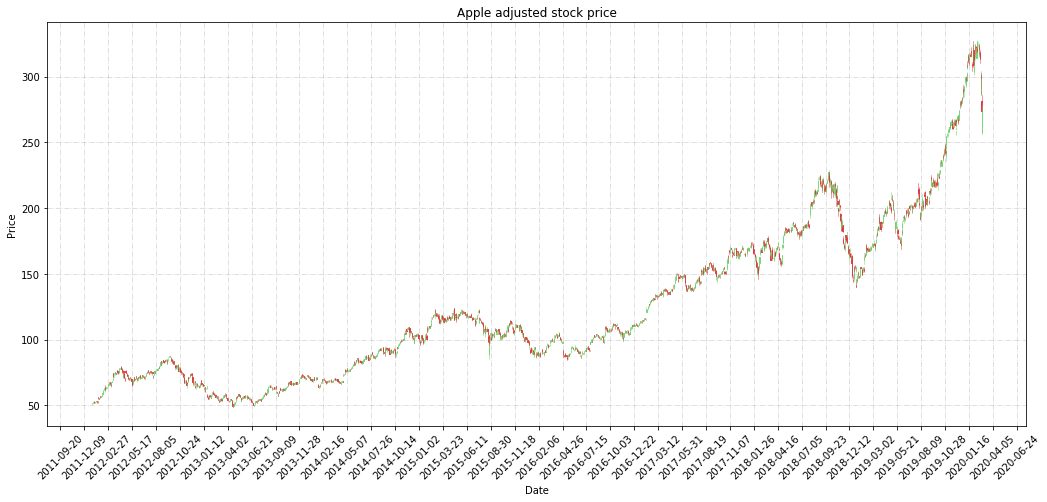

In [8]:

# Build the plot
fig = plt.figure(figsize=(16,8))
ax1 = plt.subplot2grid((1,1), (0,0))

candlestick_ohlc(ax1, apple_list, width=0.4, colorup='#77d879', colordown='#db3f3f',)

for label in ax1.xaxis.get_ticklabels():
     label.set_rotation(45)

ax1.xaxis.set_major_formatter(dates.DateFormatter('%Y-%m-%d'))
ax1.xaxis.set_major_locator(mticker.MaxNLocator(50))
ax1.grid(True, alpha=0.5, linestyle='-.')

plt.xlabel('Date')
plt.ylabel('Price')
plt.title('Apple adjusted stock price')
plt.subplots_adjust(left=0.09, bottom=0.20, right=0.94, top=0.90, wspace=0.2, hspace=0)
plt.show()

# Scaling the data

In [9]:
apple = apple[['Open', 'High', 'Low', 'Close', 'Volume']]
apple

,Open,High,Low,Close,Volume
Date,,,,,
2012-01-03,50.77,51.15,50.72,50.99,75555200
2012-01-04,50.84,51.42,50.75,51.27,65005500
2012-01-05,51.46,51.90,51.17,51.84,67817400
2012-01-06,52.05,52.42,51.99,52.38,79573200
2012-01-09,52.76,53.04,52.25,52.30,98506100
...,...,...,...,...,...
2020-02-24,297.26,304.18,289.23,298.18,55548800
2020-02-25,300.95,302.53,286.13,288.08,57668400
2020-02-26,286.53,297.88,286.50,292.65,49513700


In [10]:
data = apple.values
data[:3]

array([[5.07700e+01, 5.11500e+01, 5.07200e+01, 5.09900e+01, 7.55552e+07],
       [5.08400e+01, 5.14200e+01, 5.07500e+01, 5.12700e+01, 6.50055e+07],
       [5.14600e+01, 5.19000e+01, 5.11700e+01, 5.18400e+01, 6.78174e+07]])

#### Split the data into training and testing sets

In [11]:
test_size = 365

train_data = data[:-test_size]
test_data = data[-test_size:]

In [12]:
scaler = StandardScaler()
train_data = scaler.fit_transform(train_data)
train_data = torch.FloatTensor(train_data).to(device)
len(train_data), train_data[:3]

(1687,
 tensor([[-1.3743e+00, -1.3776e+00, -1.3598e+00, -1.3671e+00,  2.1625e-01],
         [-1.3725e+00, -1.3706e+00, -1.3590e+00, -1.3598e+00,  6.4320e-04],
         [-1.3565e+00, -1.3583e+00, -1.3481e+00, -1.3452e+00,  5.8111e-02]]))

In [13]:
scaler = StandardScaler()
test_data = scaler.fit_transform(test_data)
test_data = torch.FloatTensor(test_data).to(device)
len(test_data), test_data[:3]

(365, tensor([[ 0.0520,  0.0203, -0.0083, -0.0443,  0.4056],
         [-0.0409, -0.0030, -0.0114, -0.0367, -0.0054],
         [-0.0257, -0.0500, -0.0503, -0.0339, -0.3304]]))

In [14]:
# we split the data into 100 day sequences of open, high, low, close data
# and the target value to be the next days closing price.
def create_sequences(input_data, seq_len):
    seq = []
    L = len(input_data)
    for i in range(L-seq_len):
        train_seq = input_data[i:i+seq_len]
        train_label = input_data[i+seq_len:i+seq_len+1][0,3]
        seq.append((train_seq ,train_label))
    return seq

In [15]:
seq_len = 100
train_seq = create_sequences(train_data, seq_len)
print(f'There are {len(train_seq)} training sequences where each sequence has a shape of {train_seq[0][0].shape}')
print(f'and each sequence is paired with the closing price of the next day.')

There are 1587 training sequences where each sequence has a shape of torch.Size([100, 5])
and each sequence is paired with the closing price of the next day.


In [16]:
test_seq = create_sequences(test_data, seq_len)
print(f'There are {len(test_seq)} testing sequences where each sequence has a shape of {test_seq[0][0].shape}')
print(f'and each sequence is paired with the closing price of the next day.')

There are 265 testing sequences where each sequence has a shape of torch.Size([100, 5])
and each sequence is paired with the closing price of the next day.


In [17]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTM, self).__init__()

        self.hidden_size = hidden_size
        self.lstm = nn.LSTM(input_size, hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        
        self.h0 = torch.zeros(1, 1, hidden_size, device=device)
        
        self.c0 = torch.zeros(1, 1, hidden_size, device=device)

    def forward(self, x):        
        out_lstm, (self.h0, self.c0) = self.lstm(x.view(len(x), 1, -1), (self.h0, self.c0))
        out = self.fc(out_lstm.view(len(x), -1))
        return out[-1][0]



In [18]:
model = LSTM(5, 100, 1).to(device)
loss_function = nn.MSELoss().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

LSTM(
  (lstm): LSTM(5, 100)
  (fc): Linear(in_features=100, out_features=1, bias=True)
)


In [0]:
epochs = 40

loss_history = []
running_loss = []
for i in range(epochs):
    
    for j, (seq, labels) in enumerate(train_seq):
        seq = seq.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()

        model.h0 = torch.zeros(1, 1, model.hidden_size, device=device)
        model.c0 = torch.zeros(1, 1, model.hidden_size, device=device)

        y_pred = model(seq)

        loss = loss_function(y_pred, labels)
        loss.backward()
        optimizer.step()

        running_loss.append(loss.item())

        if j % 50 == 0:
            avg_loss = sum(running_loss) / 50
            print(f'Epoch {i+1:3}, iteration {j:5}, loss: {avg_loss}')
            loss_history.append(avg_loss)
            running_loss = []

Epoch   1, iteration     0, loss: 0.01573773503303528
Epoch   1, iteration    50, loss: 0.08222725251500379
Epoch   1, iteration   100, loss: 0.009384989873615268
Epoch   1, iteration   150, loss: 0.008651102275430277
Epoch   1, iteration   200, loss: 0.0038451242005339737
Epoch   1, iteration   250, loss: 0.006392788437689205
Epoch   1, iteration   300, loss: 0.002440603097584244
Epoch   1, iteration   350, loss: 0.003257226132627693
Epoch   1, iteration   400, loss: 0.0034969260981381465
Epoch   1, iteration   450, loss: 0.004012862036025808
Epoch   1, iteration   500, loss: 0.007942415718457597
Epoch   1, iteration   550, loss: 0.004178609370055711
Epoch   1, iteration   600, loss: 0.0021815909966244364
Epoch   1, iteration   650, loss: 0.010320644719488428
Epoch   1, iteration   700, loss: 0.0261790599298547
Epoch   1, iteration   750, loss: 0.0027935674421678412
Epoch   1, iteration   800, loss: 0.003231768114671354
Epoch   1, iteration   850, loss: 0.009020253995427083
Epoch   1,

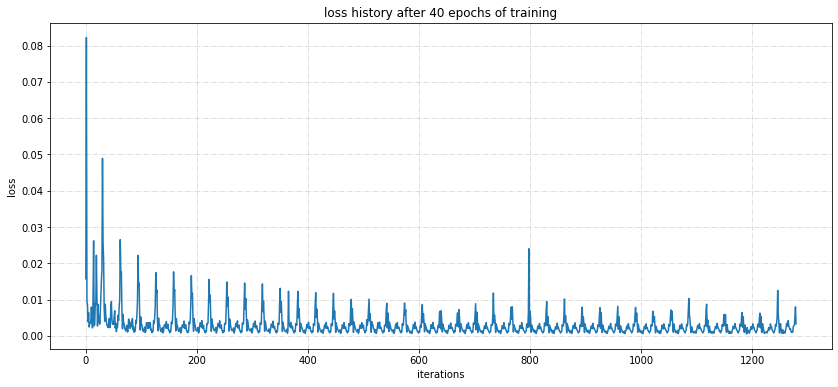

In [0]:
fig, ax1 = plt.subplots(1, 1, figsize=(14,6))

plt.title(f'loss history after {epochs} epochs of training')
ax1.plot(loss_history)
ax1.grid(alpha=.5, linestyle='-.')
plt.xlabel('iterations')
plt.ylabel('loss')

In [0]:
real_labels = []
predicted_labels = []

with torch.no_grad():
    for i, (seq, label) in enumerate(test_seq):
        seq = seq.to(device)
        label = label.to(device)
        
        model.h0 = torch.zeros(1, 1, model.hidden_size, device=device) 
        model.c0 = torch.zeros(1, 1, model.hidden_size, device=device)

        real_labels.append(label)
        predicted_labels.append(model(seq))
    

In [0]:
from sklearn.metrics import mean_absolute_error

mean_absolute_error(real_labels, predicted_labels)

0.23314852

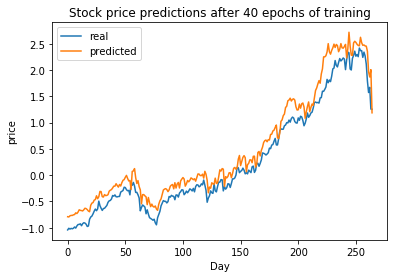

In [0]:

plt.title(f'Stock price predictions after {epochs} epochs of training')
plt.xlabel('Day')
plt.ylabel('price')
plt.plot(real_labels, label='real')
plt.plot(predicted_labels, label='predicted')
plt.legend();

# plt.savefig(f'/content/drive/My Drive/Deep Learning Final Project/{epochs}-epoch-preds1.jpg')